In [1]:
# Group number 1
# Assignment 9: Extended Kalman filter for navigation and tracking
# Team members: Stepan Perminov, Polina Ponomareva, Kirill Shcherbakov, Daniil Svirskiy

# Library importing
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
class Trajectory(object):
    def __init__(self, N, T, Xc0, Vc0, sD2, sb2, sa2, a, sbadd2):
        
        # Trajectories
        self.Xc = self.true_c_trajectory(N, T, Xc0, Vc0, sa2, a)
        self.Xp = self.true_p_trajectory(N, self.Xc)
        self.Zp = self.measurements(N, self.Xp, sD2, sb2, sbadd2)
   
    def true_c_trajectory(self, n, T, Xc0, Vc0, sa2, a):
        Xc = np.zeros((2,n))
        Vc = np.zeros((2,n))

        Xc[:, 0] = Xc0
        Vc[:, 0] = Vc0
       
        for i in range(1,n):
            Vc[:, i] = Vc[:, i-1] + a[:, i-1]*T
            Xc[:, i] = Xc[:, i-1] + Vc[:, i-1]*T + (a[:, i-1]*T*T)/2
        return Xc
    
    def true_p_trajectory(self, n, Xc):
        Xp = np.zeros((2,n))
        Xp[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2) #D
        Xp[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet
        return Xp

    def measurements(self, n, Xp, sD2, sb2, sbadd2):
        Zp = np.zeros((2,n))
        Zp[0,:] = Xp[0,:] + np.random.normal(0, np.sqrt(sD2), n) #D
        Zp[1,:] = Xp[1,:] + np.random.normal(0, np.sqrt(sb2), n) #bet
        badd = Xp[1,:] + np.random.normal(0, np.sqrt(sbadd2), n) #bet
        key = 0
        for i in range(n):
            if key == 1:
                Zp[0,i] = float('nan')
                if i > 2:
                    Zp[1,i] = badd[i]
                else:
                    Zp[1,i] = float('nan')
                key = 0
            else:
                key = 1
        return Zp

In [3]:
class Filtration(object):
    def __init__(self, Zp, N, T, sD2, sb2, sa2, sbadd2):

        # Initial conditions for Kalman filter algorithm
        X0 = np.array([Zp[0, 2]*np.sin(Zp[1, 2]), (Zp[0, 2]*np.sin(Zp[1, 2]) - Zp[0, 0]*np.sin(Zp[1, 0]))/(2*T), Zp[0, 2]*np.cos(Zp[1, 2]), (Zp[0, 2]*np.cos(Zp[1, 2]) - Zp[0, 0]*np.cos(Zp[1, 0]))/(2*T)])
        P0 = np.eye(4)*(10**4)
        F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
        G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
        Q = G.dot(G.T)*sa2
        
        # Covariance matrix of measurement error R
        R1 = np.array([[sD2, 0], [0, sb2]])
        R2 = sbadd2
        
        self.Kalman = self.Kalman_filtration(N, P0, X0, F, R1, R2, Q, Zp)
             
    def Kalman_filtration(self, n, P0, X0, F, R1, R2, Q, Zp):
        # Initialization of matrixes
        P_1 = np.zeros((4,4,n))
        X_1 = np.zeros((4,n))
        P_ = np.zeros((4,4,n))
        X_ = np.zeros((4,n))

        # Initial P for filtering
        P_[:,:,3] = P0

        # Initial X_filt for filtering
        X_[:,3] = X0
        
        key = 0

        # Kalman filtering
        for i in range(4,n):
            P_1[:,:,i] = (F.dot(P_[:,:,i-1])).dot(F.T) + Q

            X_1[:,i] = F.dot(X_[:,i-1].reshape(4,1)).reshape(4)
            
            if key == 1:
                dh = (np.array([X_1[2,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0, -X_1[0,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0])).reshape(1,4)
                K = (P_1[:,:,i].dot(dh.reshape(4,1)))/((dh.dot(P_1[:,:,i])).dot(dh.reshape(4,1)) + R2) #4 x 1
                
                bet = np.arctan(X_1[0,i]/X_1[2,i])
                X_[:,i] = (X_1[:,i].reshape(4,1) + K.dot(Zp[1,i] - bet)).reshape(4)
                P_[:,:,i] = P_1[:,:,i] - (K.dot(dh)).dot(P_1[:,:,i])
                
                key = 0

            else:
                              
                dh = np.array([[X_1[0,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0, X_1[2,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0], [X_1[2,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0, -X_1[0,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0]])              
                K = (P_1[:,:,i].dot(dh.T)).dot(inv((dh.dot(P_1[:,:,i])).dot(dh.T) + R1)) #4 on 2
            
                D = np.sqrt(X_1[0,i]**2 + X_1[2,i]**2)
                bet = np.arctan(X_1[0,i]/X_1[2,i])
                h = np.array([D, bet])

                X_[:,i] = (X_1[:,i].reshape(4,1) + K.dot(Zp[:,i].reshape(2,1) - h.reshape(2,1))).reshape(4)
                P_[:,:,i] = P_1[:,:,i] - (K.dot(dh)).dot(P_1[:,:,i])
                
                key = 1
       
        X_est = np.zeros((4,n))
        X_est[0,:] = np.sqrt(X_1[0,:]**2 + X_1[2,:]**2)
        X_est[1,:] = np.arctan(X_1[0,:]/X_1[2,:])
        X_est[2,:] = np.sqrt(X_[0,:]**2 + X_[2,:]**2)
        X_est[3,:] = np.arctan(X_[0,:]/X_[2,:])
        
        # print(X_est[1,:])
        
        return X_est

In [4]:
# Parameters
N = 500 #points
T = 2 #interval between measurements
Xc_init = np.ones(2)*1000
Vc_init = np.ones(2)*100
sigma_a2 = 0.3**2
sigma_D2 = 50**2
sigma_b2 = 0.004**2
sigma_badd2 = 0.001**2


/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in divide
/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide


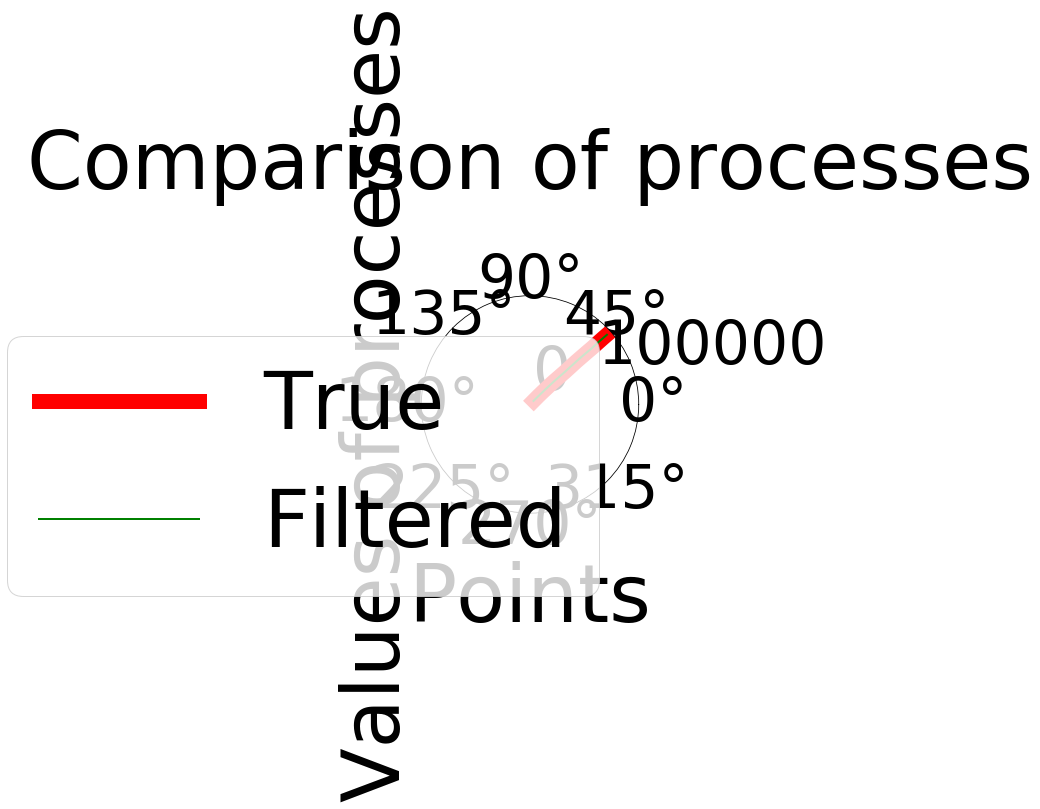

[  1448.42583967             nan   1922.94248751             nan
   2478.53154194             nan   3064.74638875             nan
   3697.61141987             nan   4343.08838594             nan
   4771.4352465              nan   5394.03941001             nan
   5919.34038073             nan   6397.20565112             nan
   7091.80917168             nan   7687.8136436              nan
   8341.93761465             nan   8776.78390253             nan
   9501.28007328             nan   9930.74057039             nan
  10550.69577584             nan  11138.38036119             nan
  11623.37273441             nan  12247.7646745              nan
  12811.221616               nan  13514.43162943             nan
  14066.92697405             nan  14605.61641398             nan
  15264.86660125             nan  15706.94616166             nan
  16322.82312142             nan  16861.63090162             nan
  17583.4949584              nan  18179.73310169             nan
  18671.72328365         

In [5]:
if __name__ == "__main__":
    a = np.zeros((2,N))
    a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    
    Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Xp
    Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Zp
    
    Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2, sigma_badd2).Kalman
    # print(Ans[2,:])
    
    plt.polar(Xp[1,3:],Xp[0,3:], linewidth = 15, label = "True", color = "r")
    # plt.polar(Zp[1,3:],Zp[0,3:], linewidth = 2, label = "Measurements", color = "b")
    plt.polar(Ans[3,3:],Ans[2,3:], linewidth = 2, label = "Filtered", color = "g")
    
    
    plt.legend(fontsize = 80)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 80)
    plt.ylabel("Values of processes", fontsize = 80)
    plt.title("Comparison of processes\n", fontsize = 80)
    plt.show()
    
    print(Zp[0,:])


/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in divide
/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide


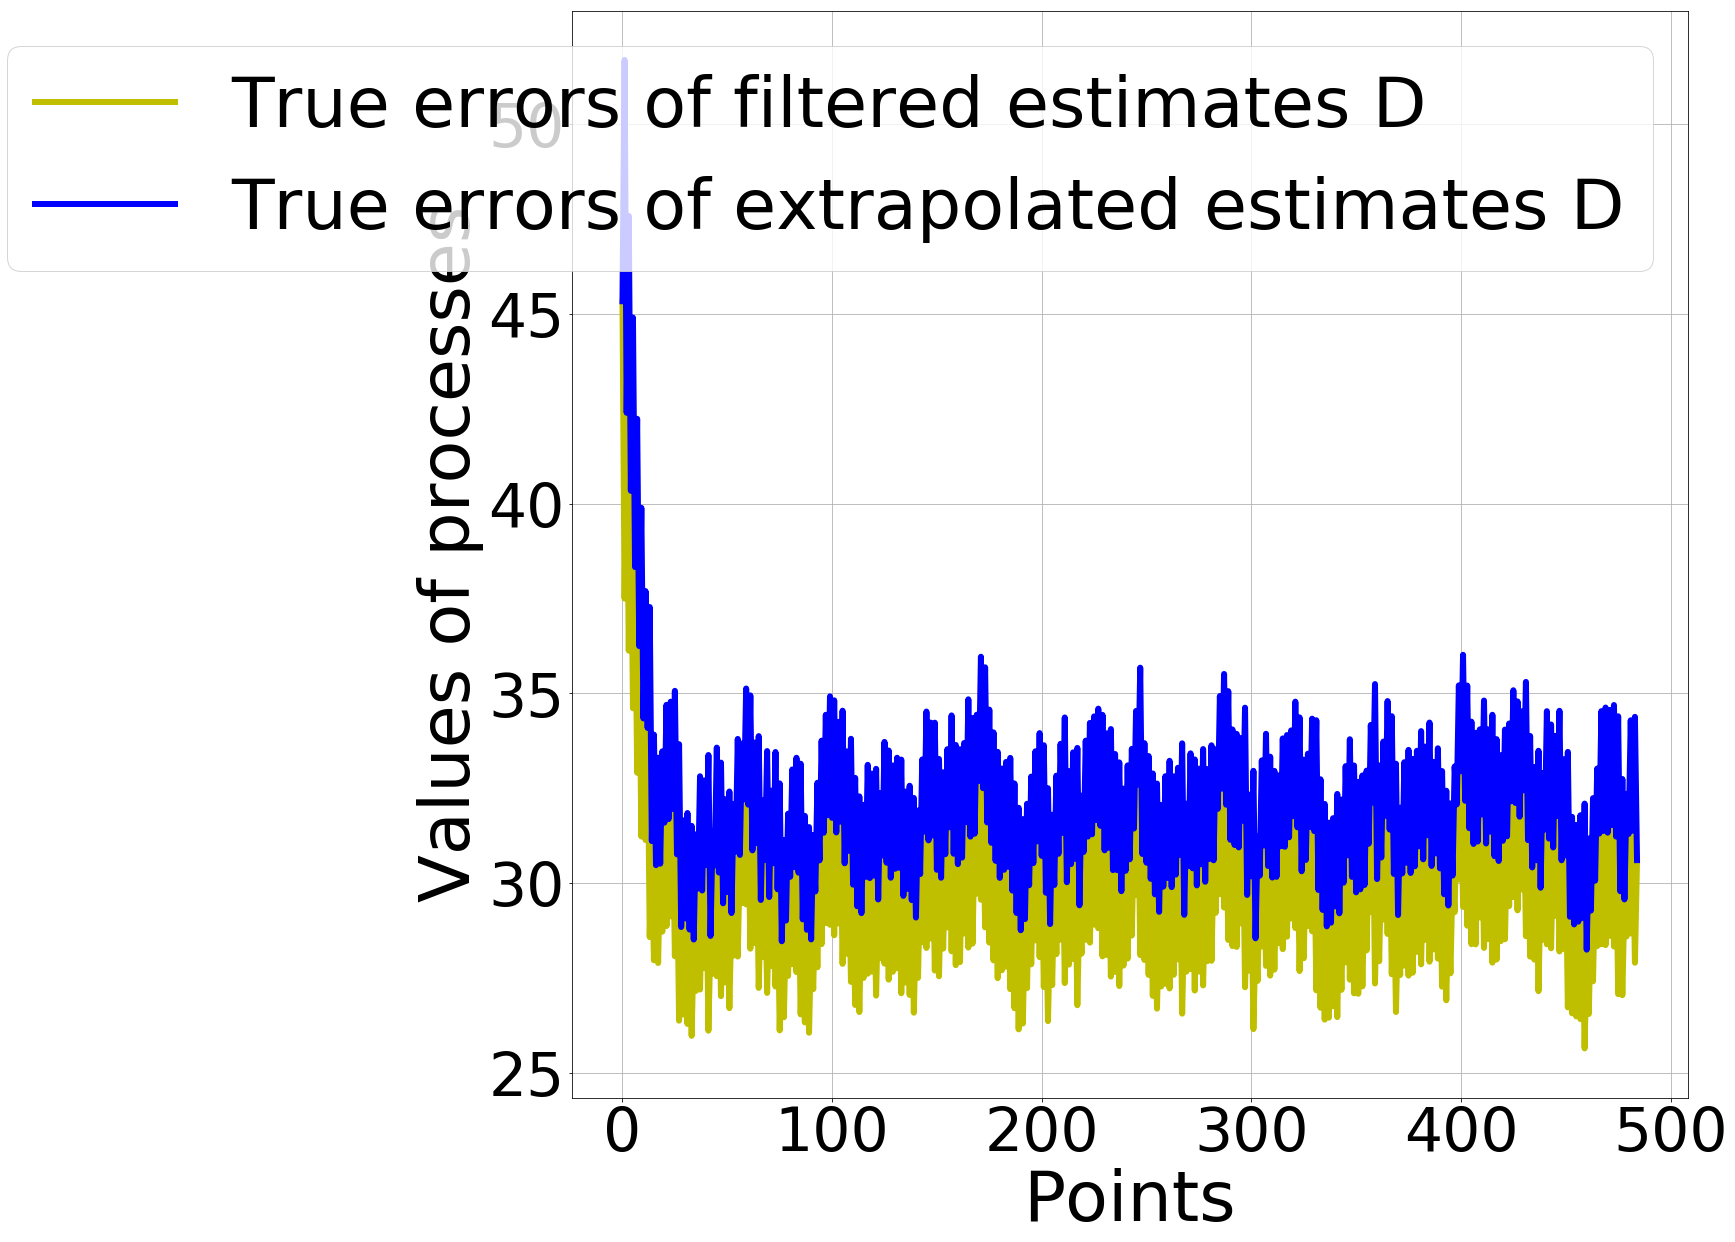

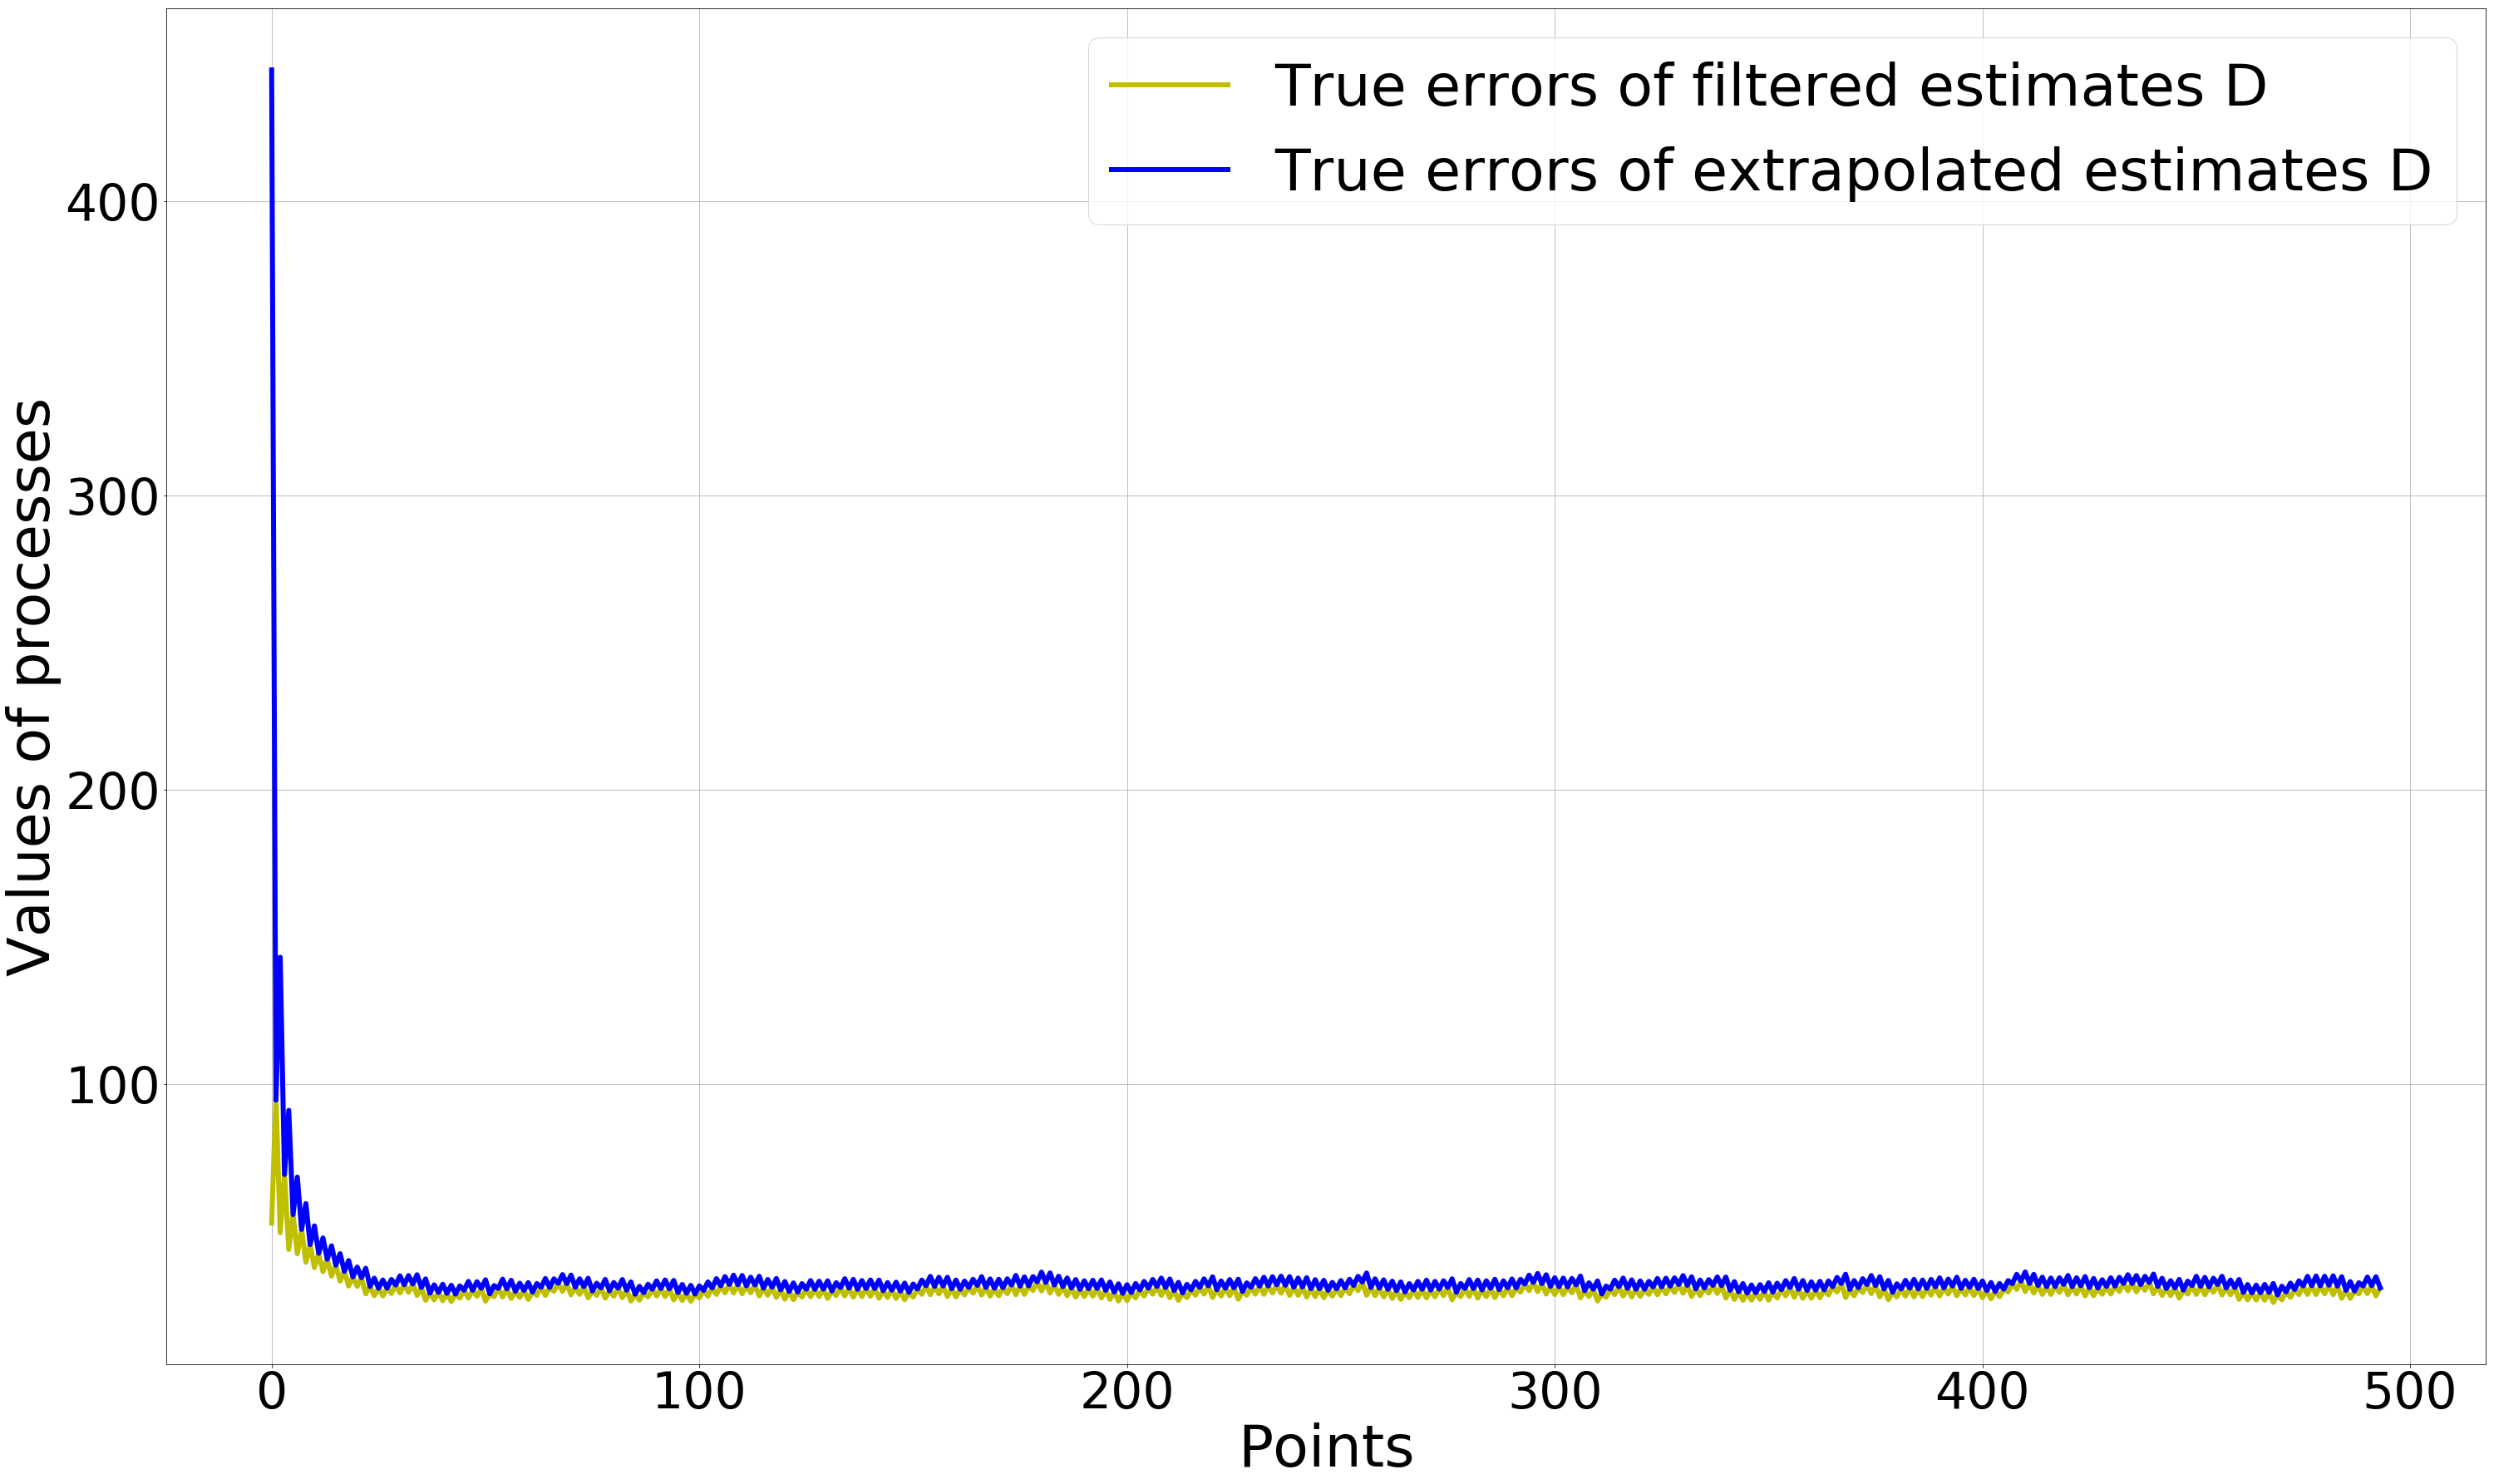

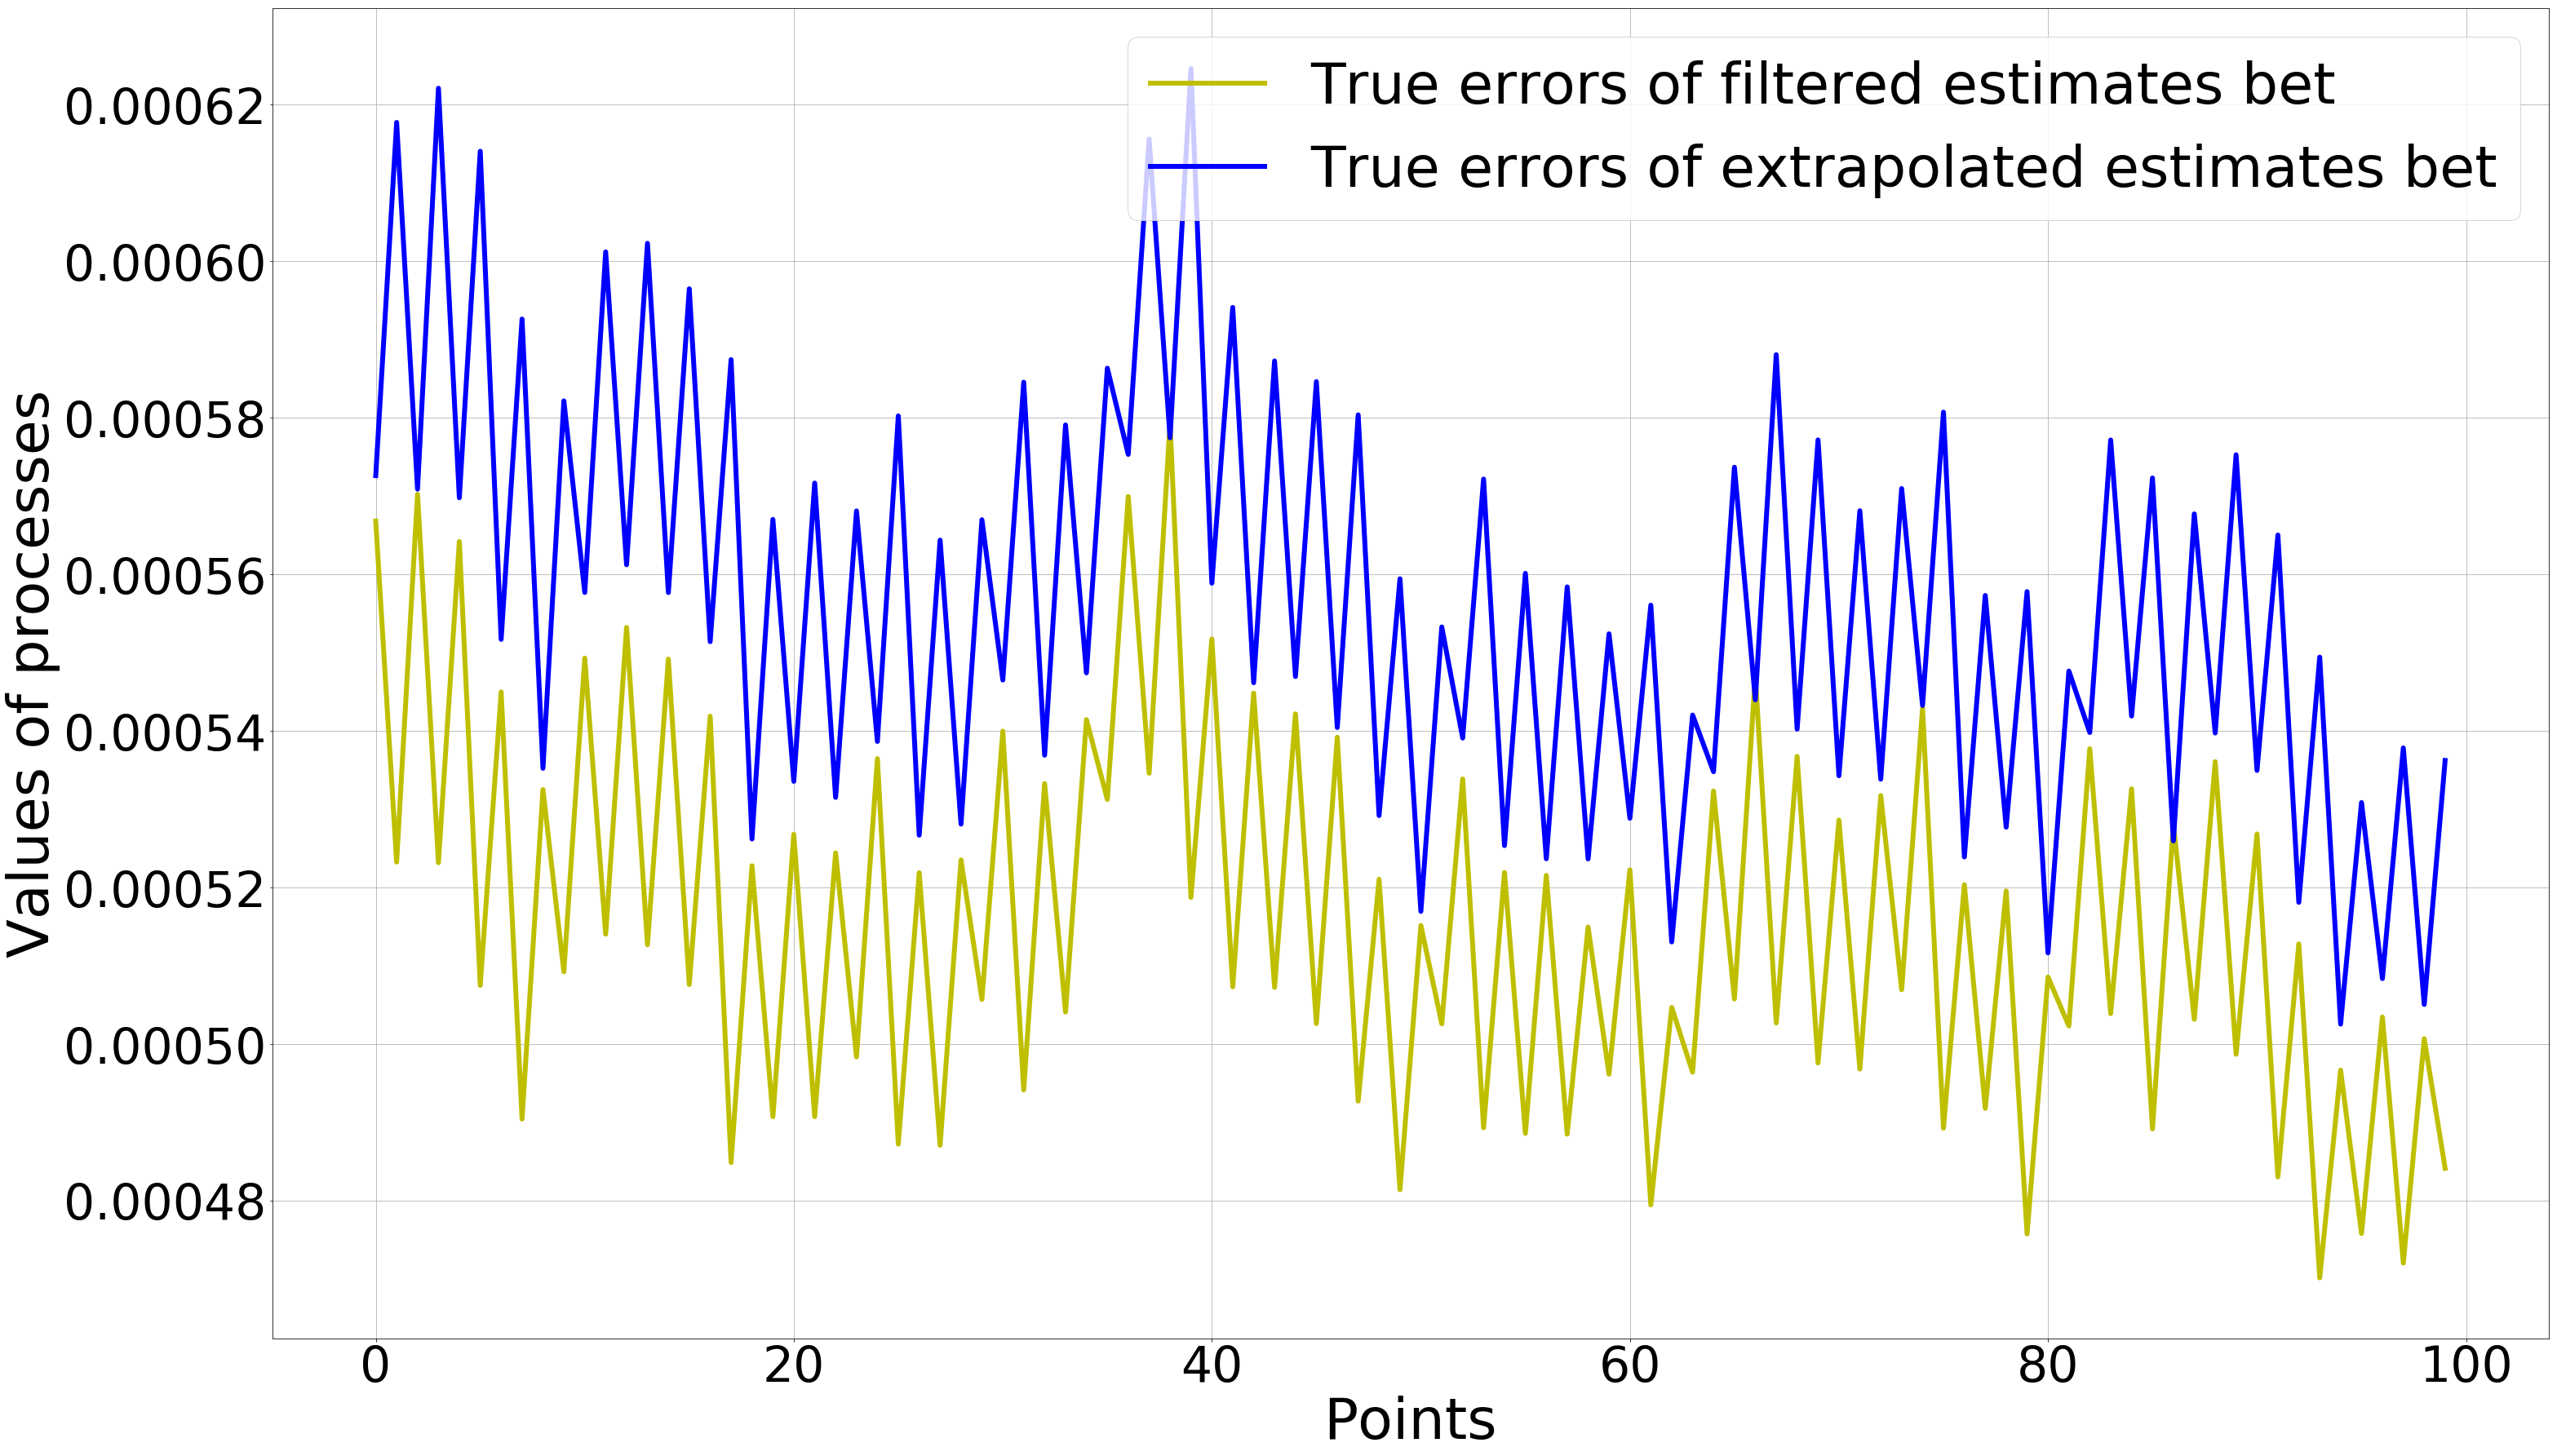

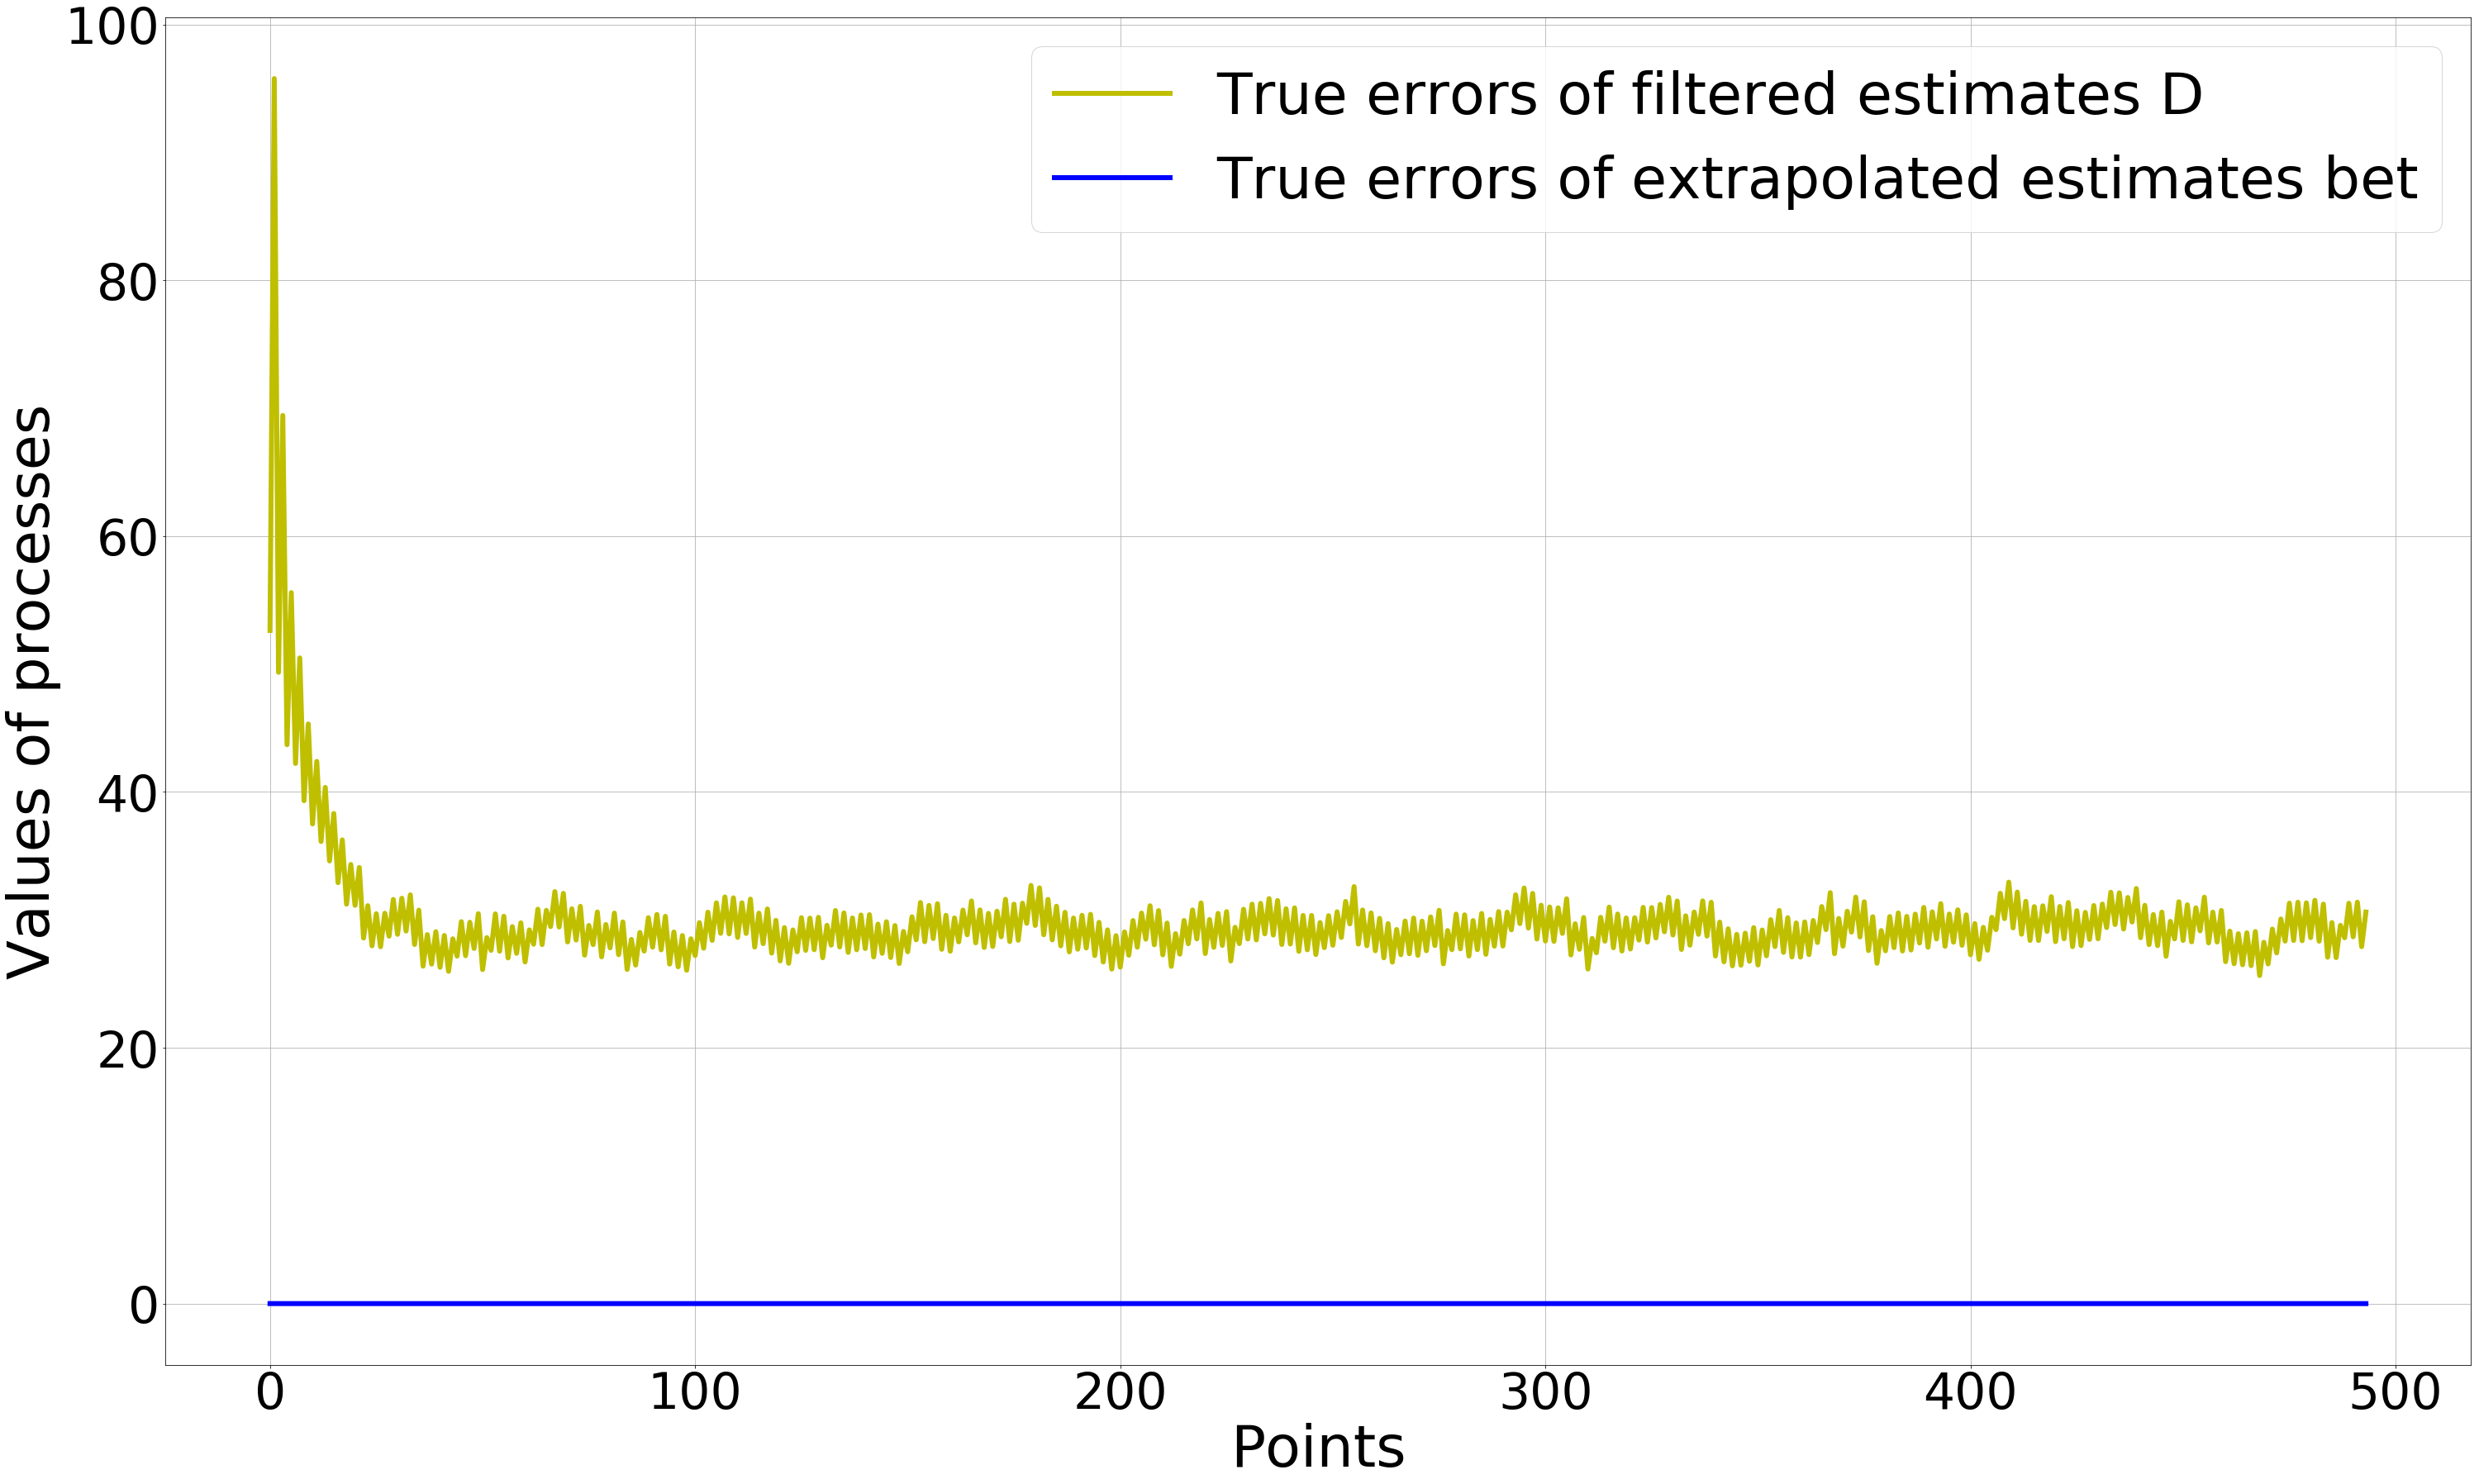

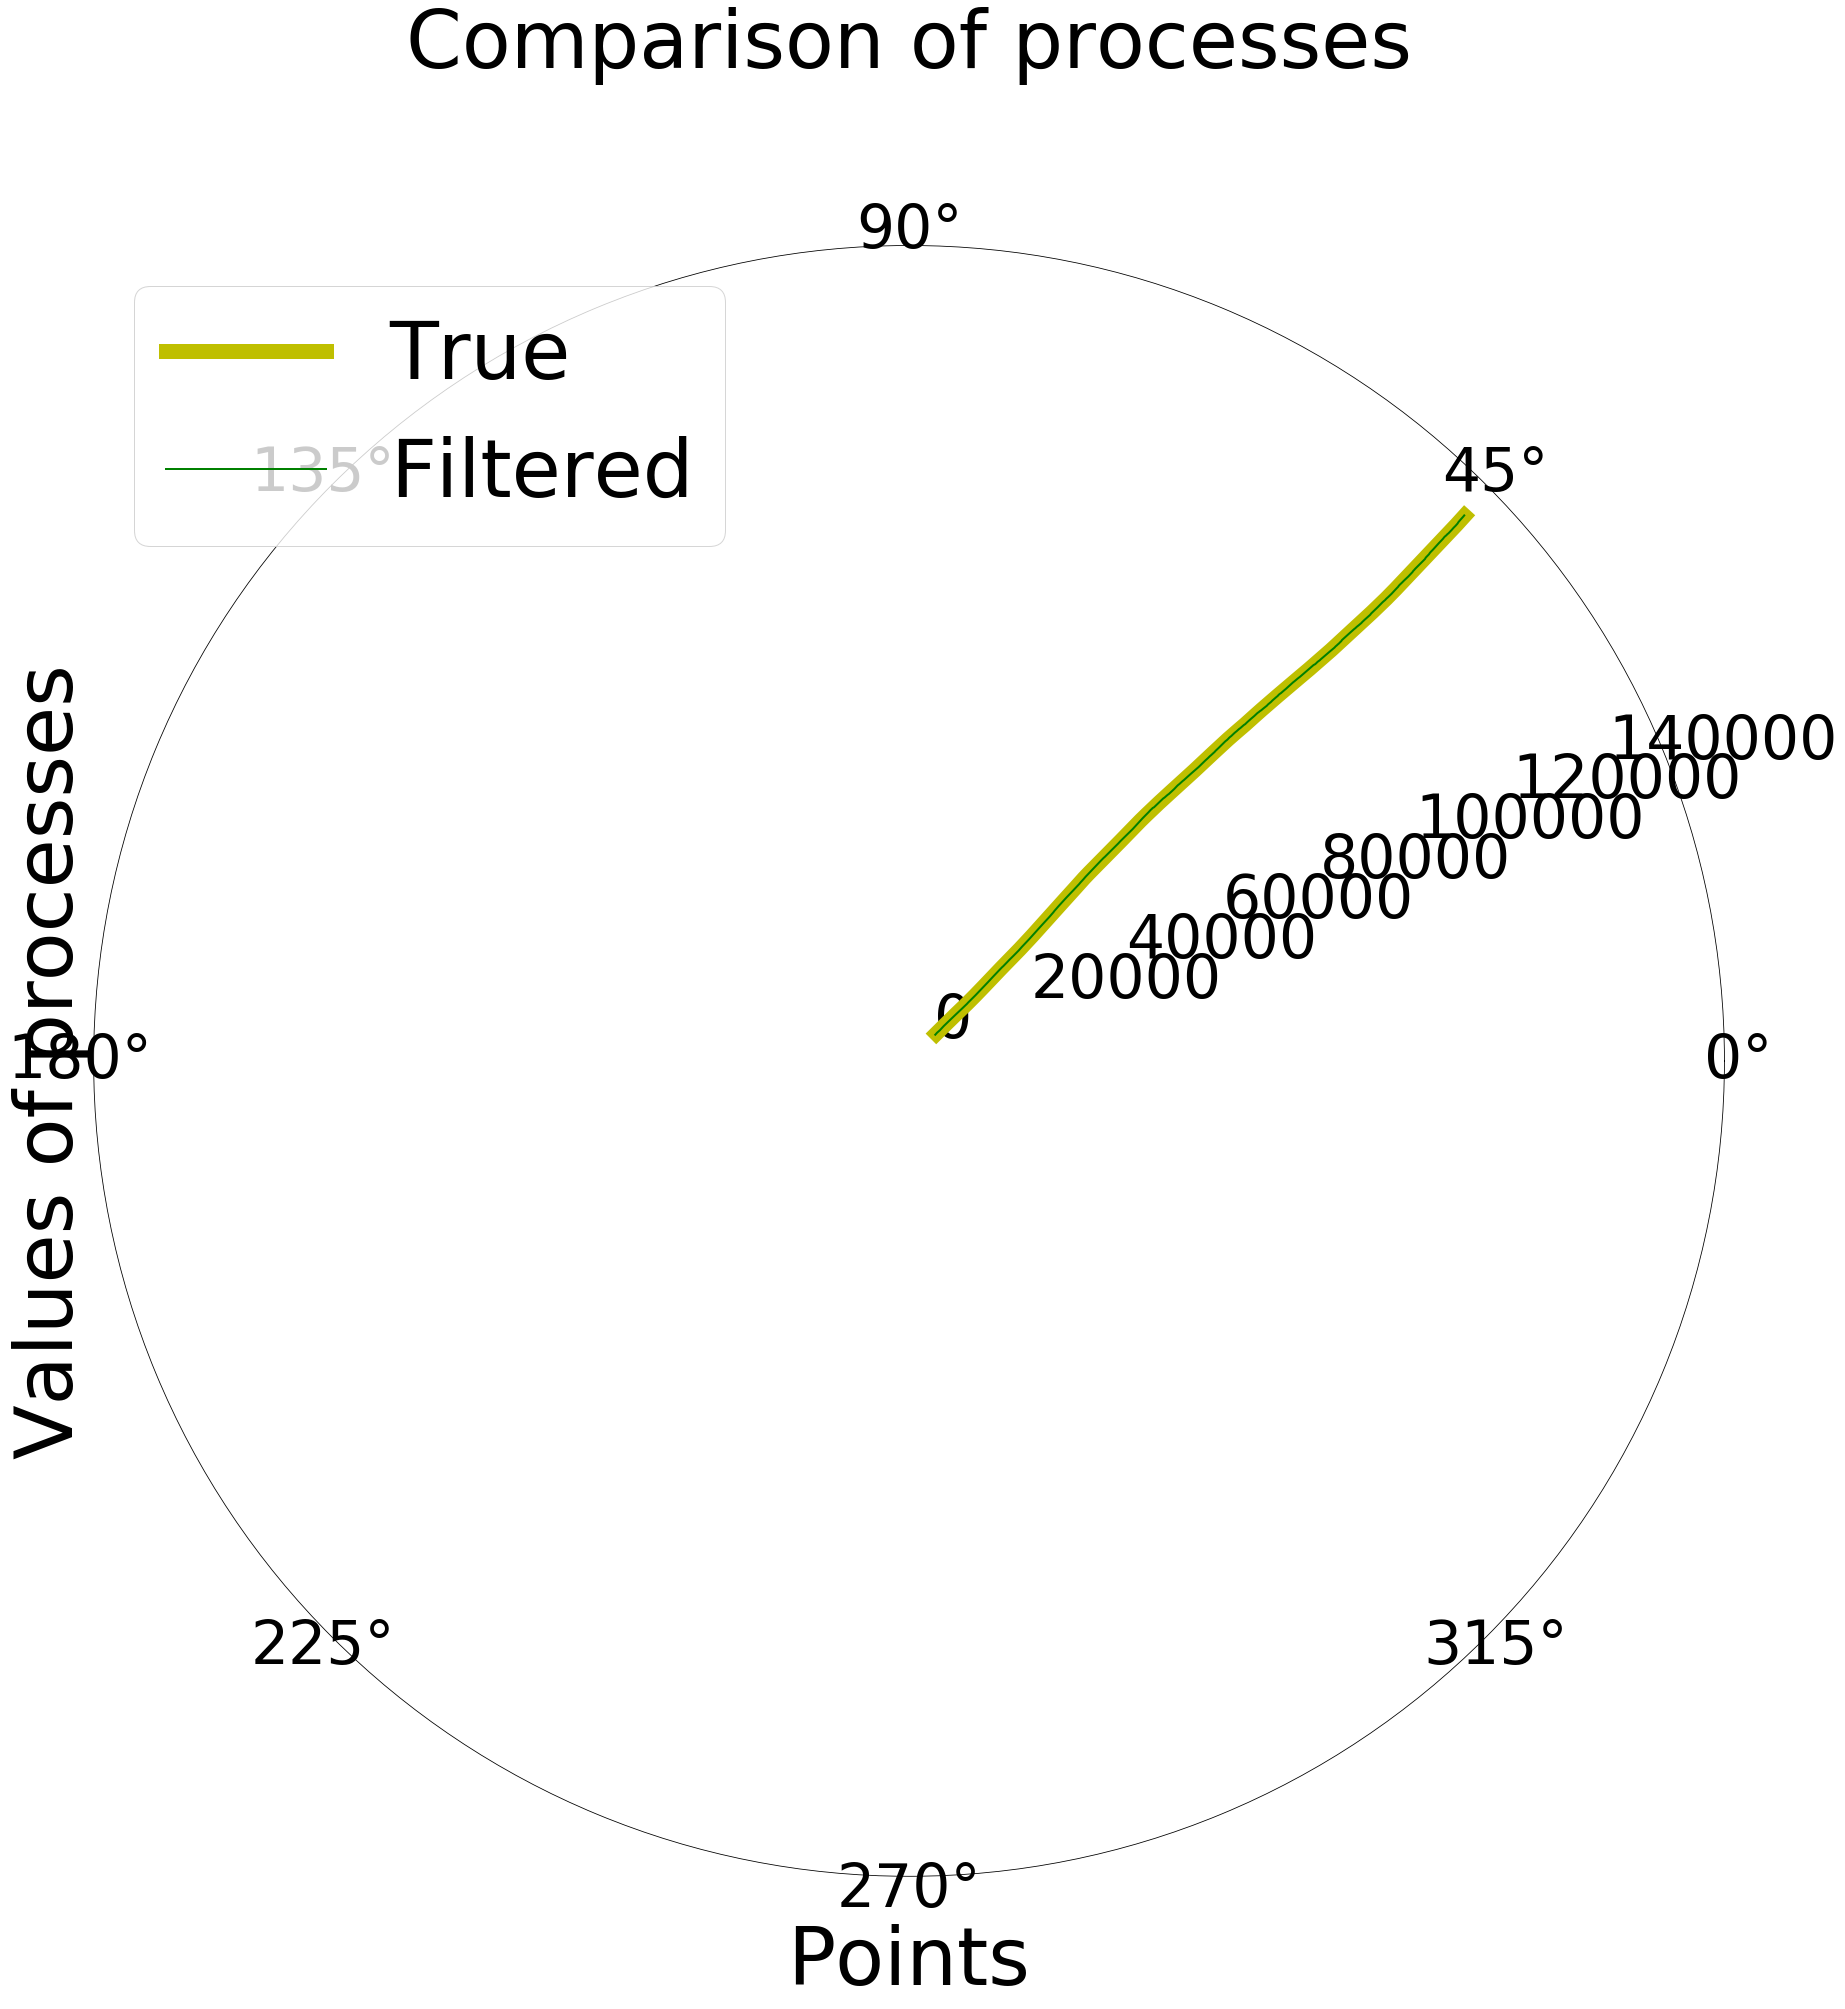

In [6]:
if __name__ == "__main__":
    
    Error_filt = np.zeros((2,N,500))
    Error_extr = np.zeros((2,N,500))
    
    for k in range(500):
        a = np.zeros((2,N))
        a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        
        Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Xp
        Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Zp
        
        Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2, sigma_badd2).Kalman
        
        est_filt = Ans[2:,:]
        est_extr = Ans[:2,:]
        Error_filt[:,:,k] = (Xp - est_filt)**2
        Error_extr[:,:,k] = (Xp - est_extr)**2

    Final_err_filt = np.sqrt(np.sum(Error_filt, axis = 2)/(500.0-1.0))
    Final_err_extr = np.sqrt(np.sum(Error_extr, axis = 2)/(500.0-1.0))

    # Compare of true errors of extrapolation and filtration of D
    plt.plot(Final_err_filt[0,15:], linewidth = 6, label = "True errors of filtered estimates D", color = "y")
    plt.plot(Final_err_extr[0,15:], linewidth = 6, label = "True errors of extrapolated estimates D", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()
    
    # Compare of true errors of extrapolation and filtration of D
    plt.plot(Final_err_filt[0,6:], linewidth = 6, label = "True errors of filtered estimates D", color = "y")
    plt.plot(Final_err_extr[0,6:], linewidth = 6, label = "True errors of extrapolated estimates D", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()
    
    plt.plot(Final_err_filt[1,200:300], linewidth = 6, label = "True errors of filtered estimates bet", color = "y")
    plt.plot(Final_err_extr[1,200:300], linewidth = 6, label = "True errors of extrapolated estimates bet", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()
    
    plt.plot(Final_err_filt[0,6:], linewidth = 6, label = "True errors of filtered estimates D", color = "y")
    plt.plot(Final_err_filt[1,6:], linewidth = 6, label = "True errors of extrapolated estimates bet", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()

    plt.polar(Xp[1,3:],Xp[0,3:], linewidth = 15, label = "True", color = "y")
    # plt.polar(Zp[1,:],Zp[0,:], linewidth = 2, label = "Measurements", color = "b")
    plt.polar(Ans[3,3:],Ans[2,3:], linewidth = 2, label = "Filtered", color = "g")
    
    
    plt.legend(fontsize = 80)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 80)
    plt.ylabel("Values of processes", fontsize = 80)
    plt.title("Comparison of processes\n", fontsize = 80)
    plt.show()
